In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import ipywidgets as widgets
from sklearn.neighbors import NearestNeighbors

# Creates dataframes
books_df = pd.read_csv("csv_files/Books.csv", low_memory=False)
books_df = books_df.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'])

ratings_df = pd.read_csv("csv_files/Ratings.csv", low_memory=False)

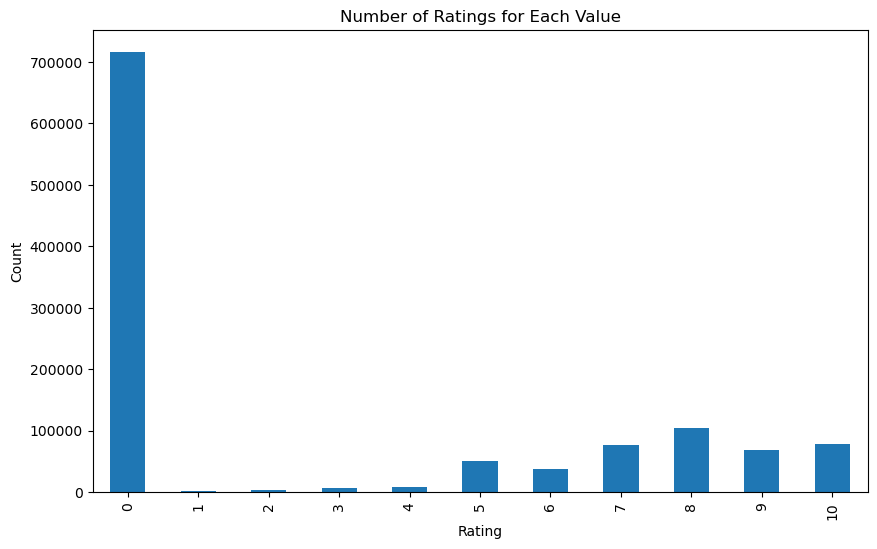

In [2]:
# Visualization for the ratings count
rating_counts = ratings_df['Book-Rating'].value_counts().sort_index()

plt.figure(figsize=(10,6))
rating_counts.plot(kind='bar')
plt.title('Number of Ratings for Each Value')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(0, 11))
plt.show()

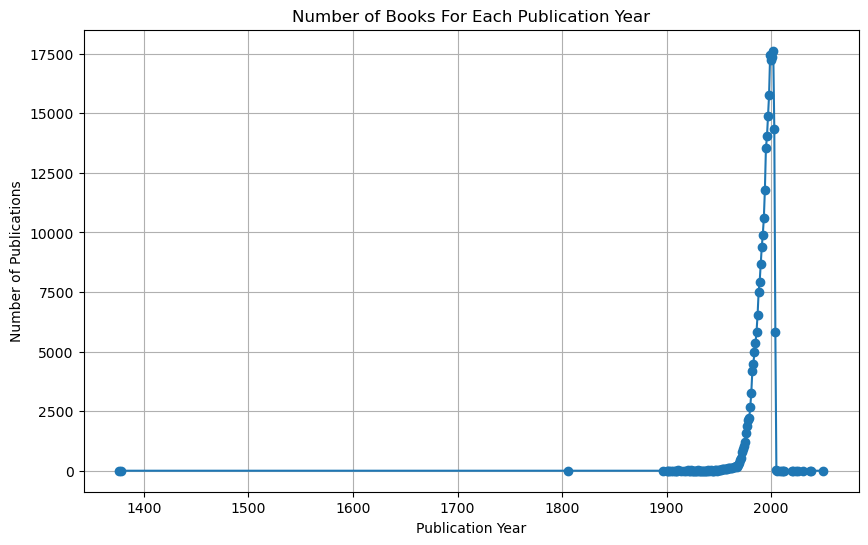

In [3]:
# Fills null values from the books dataframe
books_df.loc[:, 'Book-Author'] = books_df['Book-Author'].fillna('Unknown')
books_df.loc[:, 'Publisher'] = books_df['Publisher'].fillna('Unknown')

# This code converts the books dataframe's publication year type to integer
books_df.loc[:, 'Year-Of-Publication'] = pd.to_numeric(books_df['Year-Of-Publication'], errors='coerce')
books_df = books_df.dropna(subset=['Year-Of-Publication'])
books_df.loc[:, 'Year-Of-Publication'] = books_df['Year-Of-Publication'].astype(int)

# This code removes rows where the year of publication is 0
books_df_no_zero = books_df[books_df['Year-Of-Publication'] != 0]

# This code creates a line plot of the number of books for each publication year
year_counts = books_df_no_zero['Year-Of-Publication'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(year_counts.index, year_counts.values, marker='o')
plt.title('Number of Books For Each Publication Year')
plt.xlabel('Publication Year')
plt.ylabel('Number of Publications')
plt.grid(True)
plt.show()

In [4]:
ratings_books_df = ratings_df.merge(books_df, on='ISBN')

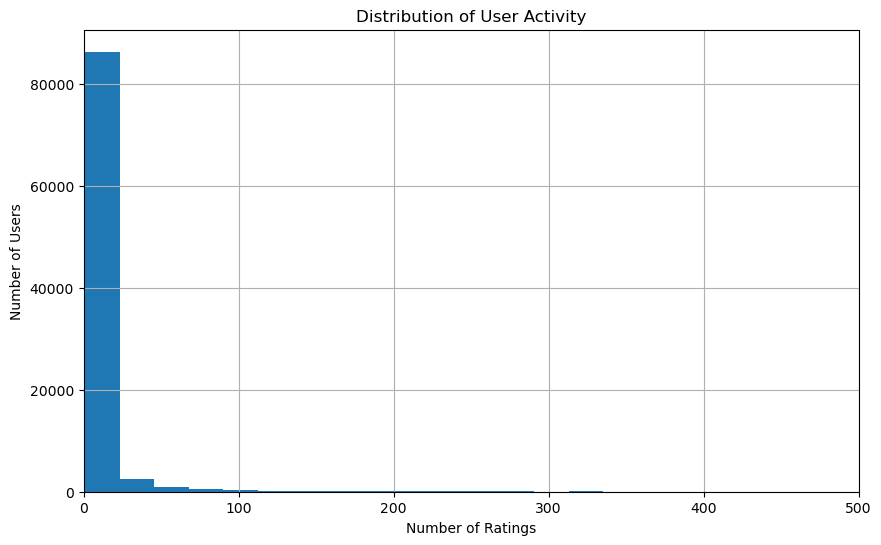

In [5]:
user_activity = ratings_books_df['User-ID'].value_counts()
plt.figure(figsize=(10, 6))
user_activity.hist(bins=500)
plt.xlim(0, 500)
plt.title('Distribution of User Activity')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

In [6]:
# Filters users with more than 100 ratings
user_filter = ratings_books_df['User-ID'].value_counts()[lambda x: x > 100].index

# Filters the dataframe based on filtered users
filtered_ratings_df = ratings_books_df[ratings_books_df['User-ID'].isin(user_filter)]

# Filters books with at least 50 ratings
book_filter = filtered_ratings_df['Book-Title'].value_counts()[lambda x: x >= 50].index

# Filters the dataframe based on filtered books
final_ratings_df = filtered_ratings_df[filtered_ratings_df['Book-Title'].isin(book_filter)]


In [7]:
# Creates a pivot table of book ratings on book title and user ID
pivot_table = final_ratings_df.pivot_table(values='Book-Rating', index='Book-Title', columns='User-ID')
pivot_table.fillna(0, inplace=True)

In [8]:
# Creates a matrix from the pivot table
pivot_table_matrix = pivot_table.values

# Creates a nearest neighbor model and fits it on the matrix
nn_model = NearestNeighbors(algorithm='brute', metric='cosine')
nn_model.fit(pivot_table_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [9]:
# Uses the model to find the 5 nearest neighbors for each entry in the matrix
distances, indices = nn_model.kneighbors(pivot_table_matrix, n_neighbors= 5)

# Creates a new matrix to store the predicted ratings
predicted_matrix = np.zeros(pivot_table_matrix.shape)

# Iterates over each row in the indices array
for i, neighbors in enumerate(indices):
    # Iterates over each neighbor in the neighbors array
    for neighbor in neighbors:
        # Adds the neighbor's ratings to the predicted matrix
        predicted_matrix[i,:] += pivot_table_matrix[neighbor,:]

# Divides the predicted matrix by the number of neighbors to get the average rating
predicted_matrix /= len(neighbors)

In [10]:
# Creates lists for storing precision, recall, and k values
k_values = list(range(1,26))
precision_list = []
recall_list = []

# Iterates over different k values
for k in k_values:
    user_precision_list = []
    user_recall_list = []

    # Gets the number of users in the pivot table
    user_num = pivot_table_matrix.shape[0]

    # Iterates over each user in the pivot table
    for user_id in range(user_num):
        # Gets the items that the user has rated
        items = np.where(pivot_table_matrix[user_id, :] > 0)[0]
    
        # Skips users with no ratings
        if len(items) == 0:
            continue
    
        # Gets the predicted scores for the user
        predicted_scores = predicted_matrix[user_id,:]
    
        # Sorts the predicted scores in descending order and gets the top k items
        top_k_items = np.argsort(predicted_scores)[::-1][:k]
    
        # Performs a set intersection to return true positives
        true_positives = len(set(top_k_items) & set(items))
    
        # Calculates precision and recall
        precision = true_positives / k
        recall = true_positives / len(items)
    
        # Appends precision and recall to their respective lists
        user_precision_list.append(precision)
        user_recall_list.append(recall)

    # Calculates the average precision and recall
    precision_list.append(np.mean(user_precision_list))
    recall_list.append(np.mean(user_recall_list))

#for k in k_values:
#    print('Precision at K = ', k, ': ', round(precision_list[k-1], 2), '     Recall at K = ', k, ': ', round(recall_list[k-1], 2))

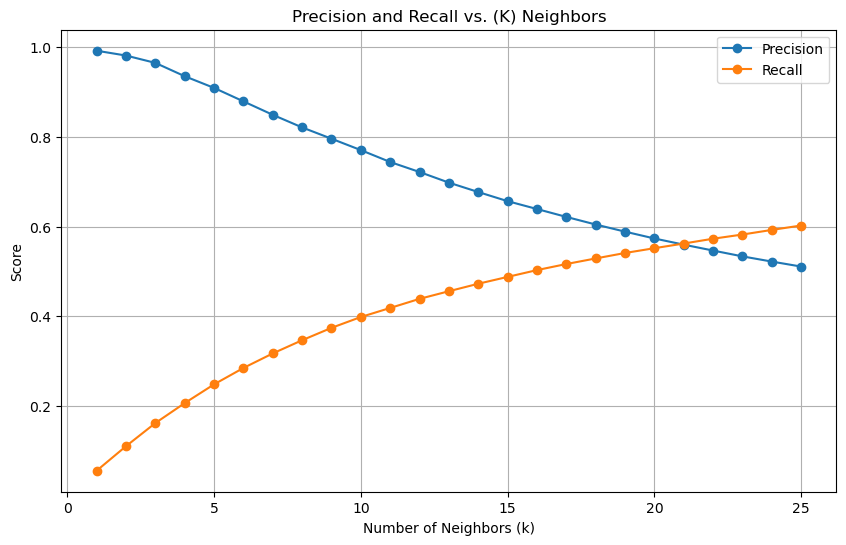

In [11]:
# Plots precision and recall against k
plt.figure(figsize=(10, 6))
plt.plot(k_values, precision_list, label='Precision', marker='o')
plt.plot(k_values, recall_list, label='Recall', marker='o')

plt.title('Precision and Recall vs. (K) Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

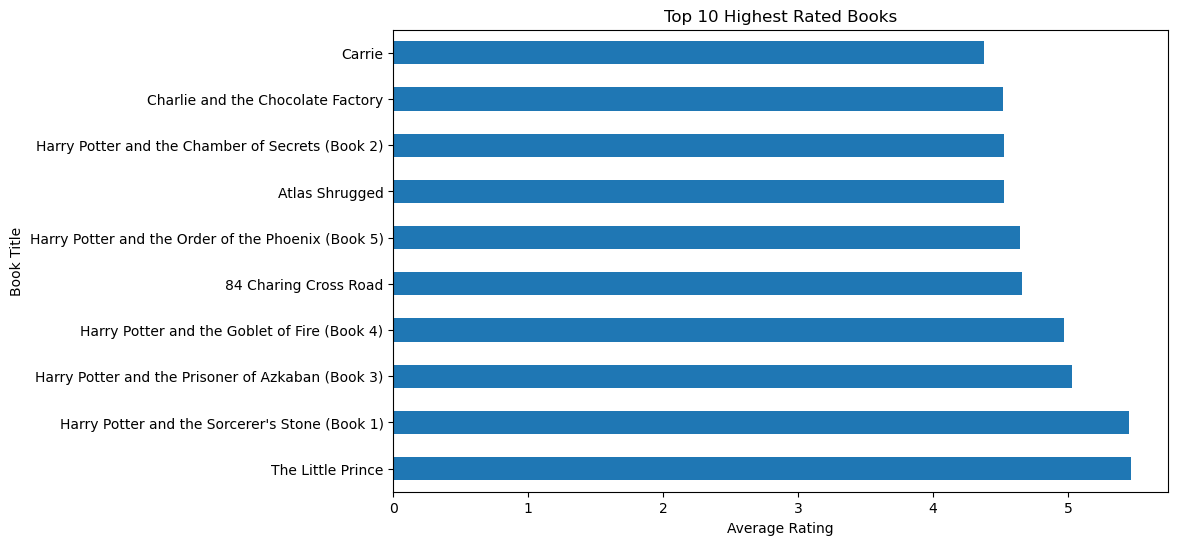

In [12]:
top_rated_books = final_ratings_df.groupby('Book-Title')['Book-Rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_rated_books.plot(kind='barh')
plt.title('Top 10 Highest Rated Books')
plt.xlabel('Average Rating')
plt.ylabel('Book Title')
plt.show()

In [13]:
# Creates a function that will recommend books based on an input string
def recommend(book_name):
    try:
        # Finds the index of the book in the pivot table
        book_index = np.where(pivot_table.index.str.lower() == book_name.lower())[0][0]

        # Finds the nearest neighbors of the book
        distances, indices = nn_model.kneighbors(pivot_table.iloc[book_index, :].values.reshape(1, -1), n_neighbors = 11)

        # Prints the recommended books
        for i in range(1, len(indices[0])):
            recommended_book_index = indices[0][i]
            recommended_book_name = pivot_table.index[recommended_book_index]
            print(recommended_book_name)

    # Handles the case where the book is not found
    except IndexError:
        print('Book could not be found!')

In [14]:
# Creates a text box that takes user input
text = widgets.Text(description='Book Title', style={'description_width': 'initial'})

# Creates an output widget and submit button
text_output = widgets.Output()
submit_button = widgets.Button(description='Submit', button_style='success')

# Creates a function that will be called when the submit button is pressed
def on_button_pressed(button):
    # Calls the recommend function with the user input
    with text_output:
      text_output.clear_output()
      if text.value == '':
        print('Please enter a book title!')
      else:
        # Clears the output of text so as to not crowd the space with subsequent recommendations
        recommend(text.value)

# Displays the widgets
display(text, submit_button, text_output)
submit_button.on_click(on_button_pressed)

Text(value='', description='Book Title', style=TextStyle(description_width='initial'))

Button(button_style='success', description='Submit', style=ButtonStyle())

Output()